## Inventory Forecasting Analysis

In [1]:
#Grab historical Sales data
#Seasonality Variables, Qtr, Period
#Event sku?
# Sku age
# CPI
#%matplotlib inline

In [2]:
print(str(60000*60*365))

1314000000


In [3]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")

import HelperPI
import seaborn as sbs
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts

In [4]:
helper = HelperPI.Helper()

INFO:root:Initializing...


### Grabbing the data via pyodbc

In [5]:
sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\InventoryForecasting.sql")

In [6]:
base, dtypesdf = helper.readData(sql)

INFO:root:Reading data...
INFO:root:Data read complete...
INFO:root:Read: 244 rows.


                   Count     Column Type
0      FIRST_DAY_OF_WEEK  datetime64[ns]
1       CALENDAR_QUARTER           int64
2                  MNTH1           int64
3                  MNTH2           int64
4                  MNTH3           int64
5                  MNTH4           int64
6                  MNTH5           int64
7                  MNTH6           int64
8                  MNTH7           int64
9                  MNTH8           int64
10                MNTH10           int64
11                MNTH11           int64
12                MNTH12           int64
13          HOLIDAY_WEEK           int64
14               UMCSENT         float64
15          STORE_NUMBER          object
16  STYLE_DISPLAY_NUMBER          object
17    SKU_DISPLAY_NUMBER          object
18                 PRICE         float64
19               SKU_AGE           int64
20             EVENT_SKU           int64
21          TARGET_UNITS         float64


In [7]:
base.describe()

CALENDAR_QUARTER       MNTH1       MNTH2       MNTH3       MNTH4  \
count        244.000000  244.000000  244.000000  244.000000  244.000000   
mean           2.405738    0.102459    0.077869    0.086066    0.086066   
std            1.105229    0.303874    0.268516    0.281037    0.281037   
min            1.000000    0.000000    0.000000    0.000000    0.000000   
25%            1.000000    0.000000    0.000000    0.000000    0.000000   
50%            2.000000    0.000000    0.000000    0.000000    0.000000   
75%            3.000000    0.000000    0.000000    0.000000    0.000000   
max            4.000000    1.000000    1.000000    1.000000    1.000000   

            MNTH5       MNTH6       MNTH7       MNTH8      MNTH10      MNTH11  \
count  244.000000  244.000000  244.000000  244.000000  244.000000  244.000000   
mean     0.118852    0.077869    0.073770    0.081967    0.065574    0.086066   
std      0.324280    0.268516    0.261934    0.274879    0.248044    0.281037   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           MNTH12  HOLIDAY_WEEK     UMCSENT         PRICE  SKU_AGE  \
count  244.000000    244.000000  244.000000  2.440000e+02    244.0   
mean     0.069672      0.245902   90.484426  6.790000e+00   9442.0   
std      0.255117      0.431506    5.322899  2.225010e-14      0.0   
min      0.000000      0.000000   80.000000  6.790000e+00   9442.0   
25%      0.000000      0.000000   87.200000  6.790000e+00   9442.0   
50%      0.000000      0.000000   91.300000  6.790000e+00   9442.0   
75%      0.000000      0.000000   94.700000  6.790000e+00   9442.0   
max      1.000000      1.000000   98.500000  6.790000e+00   9442.0   

        EVENT_SKU  TARGET_UNITS  
count  244.000000    244.000000  
mean     0.069672     84.540984  
std      0.255117    218.501524  
min      0.000000      1.000000  
25%      0.000000     21.000000  
50%      0.000000     41.000000  
75%      0.000000     71.250000  
max      1.000000   2180.000000

In [8]:
base.head()

FIRST_DAY_OF_WEEK  CALENDAR_QUARTER  MNTH1  MNTH2  MNTH3  MNTH4  MNTH5  \
0        2013-12-29                 1      1      0      0      0      0   
1        2013-12-29                 1      1      0      0      0      0   
2        2014-01-05                 1      1      0      0      0      0   
3        2014-01-12                 1      1      0      0      0      0   
4        2014-01-19                 1      1      0      0      0      0   

   MNTH6  MNTH7  MNTH8      ...       MNTH12  HOLIDAY_WEEK  UMCSENT  \
0      0      0      0      ...            0             1     81.2   
1      0      0      0      ...            0             0     81.2   
2      0      0      0      ...            0             0     81.2   
3      0      0      0      ...            0             0     81.2   
4      0      0      0      ...            0             0     81.2   

   STORE_NUMBER  STYLE_DISPLAY_NUMBER SKU_DISPLAY_NUMBER PRICE SKU_AGE  \
0           001             145-28634             214423  6.79    9442   
1           001             145-28634             214423  6.79    9442   
2           001             145-28634             214423  6.79    9442   
3           001             145-28634             214423  6.79    9442   
4           001             145-28634             214423  6.79    9442   

   EVENT_SKU  TARGET_UNITS  
0          0           5.0  
1          0          29.0  
2          0          68.0  
3          0          53.0  
4          0          56.0  

[5 rows x 22 columns]

# Preliminary OLS results

In [9]:
formula = 'TARGET_UNITS ~ C(MNTH1) + C(MNTH2) + C(MNTH3) + C(MNTH4) + C(MNTH5) + C(MNTH6) + C(MNTH7) + C(MNTH8) + C(MNTH10) + C(MNTH11) + C(MNTH12) + C(EVENT_SKU) + C(HOLIDAY_WEEK) + PRICE + SKU_AGE + UMCSENT'
model = sts.ols(formula, data=base).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TARGET_UNITS   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     15.92
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           9.03e-27
Time:                        10:49:29   Log-Likelihood:                -1577.2
No. Observations:                 244   AIC:                             3184.
Df Residuals:                     229   BIC:                             3237.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -8.045e-07   2.13e-06     -0.378      0.706      -5e-06    3.39e-06
C(MNTH1)[T.1]            8.9114     50.647      0.176      0.860     -90.882     108.705
C(MNTH2)[T.1]           12.7986     57.627      0.222      0.824    -100.748     126.346
C(MNTH3)[T.1]          119.0474     52.295      2.276      0.024      16.006     222.089
C(MNTH4)[T.1]           35.1647     52.722      0.667      0.505     -68.717     139.047
C(MNTH5)[T.1]           -5.0350     49.019     -0.103      0.918    -101.622      91.552
C(MNTH6)[T.1]          -22.5604     53.410     -0.422      0.673    -127.799      82.678
C(MNTH7)[T.1]            9.2323     53.440      0.173      0.863     -96.064     114.528
C(MNTH8)[T.1]            5.9736     52.098      0.115      0.909     -96.679     108.627
C(MNTH10)[T.1]           1.4377     55.564      0.026      0.979    -108.045     110.920
C(MNTH11)[T.1]         -10.7399     52.203     -0.206      0.837    -113.600      92.120
C(MNTH12)[T.1]          22.1384     57.042      0.388      0.698     -90.257     134.533
C(EVENT_SKU)[T.1]      580.0635     47.691     12.163      0.000     486.095     674.032
C(HOLIDAY_WEEK)[T.1]     7.2941     26.968      0.270      0.787     -45.843      60.431
PRICE                -5.463e-06   1.45e-05     -0.378      0.706    -3.4e-05     2.3e-05
SKU_AGE                 -0.0076      0.020     -0.378      0.706      -0.047       0.032
UMCSENT                  1.0979      2.121      0.518      0.605      -3.082       5.278
==============================================================================
Omnibus:                      271.197   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18072.780
Skew:                           4.367   Prob(JB):                         0.00
Kurtosis:                      44.248   Cond. No.                     4.41e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.12e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Data Description

In [103]:
a = model.get_influence()
a.summary_table()

<class 'statsmodels.iolib.table.SimpleTable'>

### Point Biserial Correlation
For Target_Units vs the Event Sku flag.

In [11]:
corr, pval = stats.pointbiserialr(base['HOLIDAY_WEEK'], base['TARGET_UNITS'])
print('Point Biserial Correlation \n Coeff: ' + str(corr) + '\n pval: ' + str(pval))

Point Biserial Correlation 
 Coeff: 0.0734226039962
 pval: 0.0304477063406


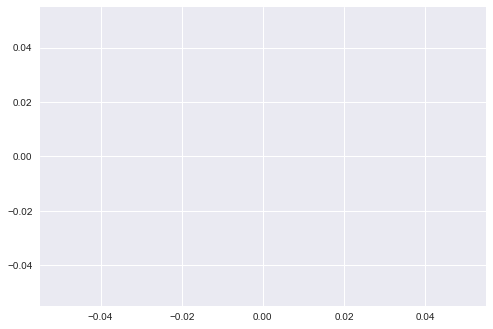

In [66]:
plt.plot(x=base['HOL14DAYPRE'], y=base['TARGET_UNITS'])
plt.show()